Two Bidimensional Unimodal Gaussian Classes.
100 batches of 950 instances



METHOD: Static lp as classifier
Execution time:  1.7445184281396946
Average MCC:  -0.1131934675025672
Average error: 56.0286
Average macro-F1: 0.4392269988904768
Average micro-F1: 0.4442000000000001
Acurácia Média:  43.9714
Desvio Padrão:  34.898802444210034
Variância:  1217.9264120400003


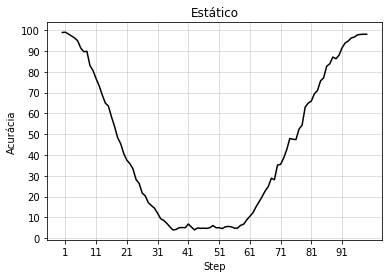

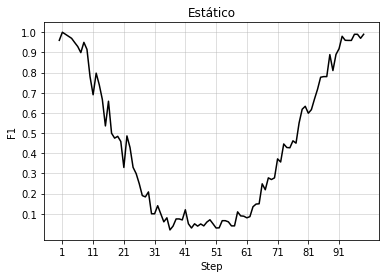




METHOD: Sliding lp as classifier
Execution time:  1.225822193014403
Average MCC:  0.9016203318149555
Average error: 5.182399999999973
Average macro-F1: 0.9497978708740622
Average micro-F1: 0.9502999999999999
Acurácia Média:  94.81760000000003
Desvio Padrão:  4.189449157108844
Variância:  17.551484240000004


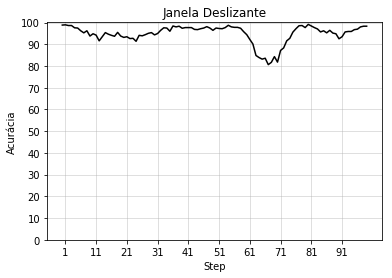

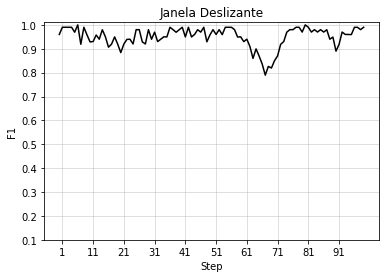




METHOD: Incremental lp as classifier
Execution time:  42.049535140561936
Average MCC:  -0.08392024151534513
Average error: 54.60509999999999
Average macro-F1: 0.4563089549811464
Average micro-F1: 0.4586
Acurácia Média:  45.39490000000001
Desvio Padrão:  33.223445170391344
Variância:  1103.79730899


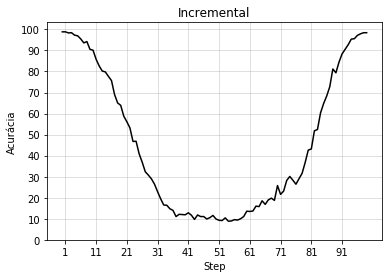

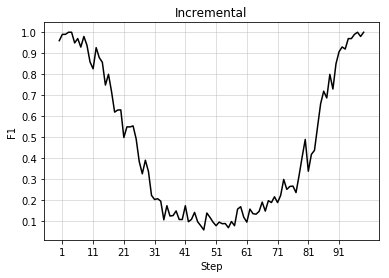




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  6.397685670859055
Average MCC:  0.32564581596441455
Average error: 33.52979999999998
Average macro-F1: 0.6614470454696079
Average micro-F1: 0.6626000000000001
Acurácia Média:  66.47020000000002
Desvio Padrão:  41.917049036877586
Variância:  1757.0389999600002


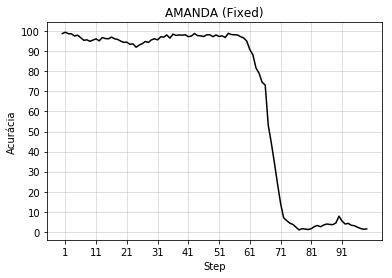

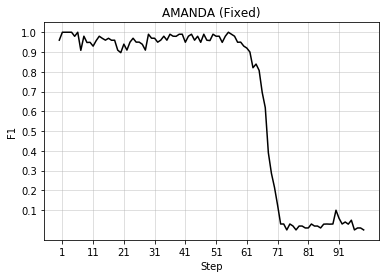




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.33 | Std keeping percentage=0.19
Execution time:  6.695696135289289
Average MCC:  0.9155054194522085
Average error: 4.456800000000015
Average macro-F1: 0.9571215574674414
Average micro-F1: 0.9574999999999999
Acurácia Média:  95.54319999999998
Desvio Padrão:  3.538464039664667
Variância:  12.520727759999994


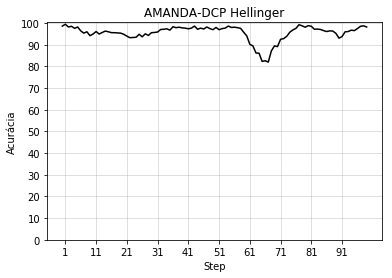

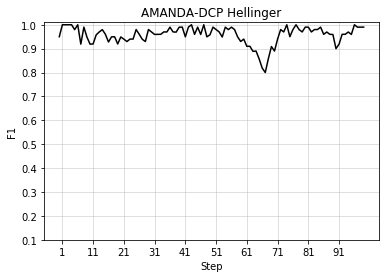




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.30 | Std keeping percentage=0.10
Execution time:  6.768638930504494
Average MCC:  0.9147033784695862
Average error: 4.352500000000006
Average macro-F1: 0.9566821831976654
Average micro-F1: 0.9571
Acurácia Média:  95.6475
Desvio Padrão:  3.6740414736363545
Variância:  13.498580749999995


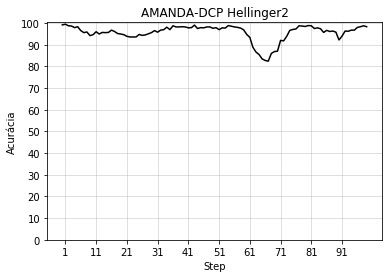

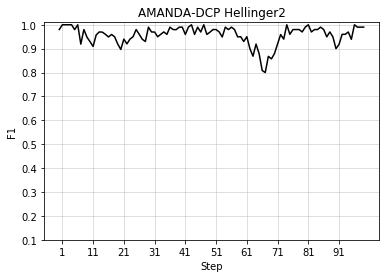




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.21 | Std keeping percentage=0.08
Execution time:  6.654278812405664
Average MCC:  0.9141502820988989
Average error: 4.410899999999998
Average macro-F1: 0.9565177323873172
Average micro-F1: 0.9569
Acurácia Média:  95.5891
Desvio Padrão:  3.769732111171827
Variância:  14.210880190000001


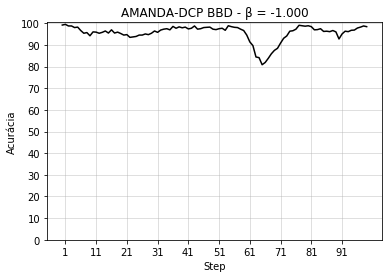

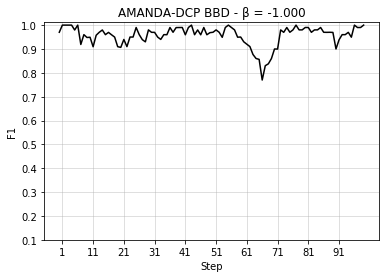

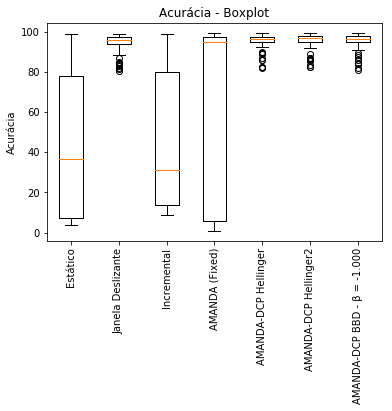

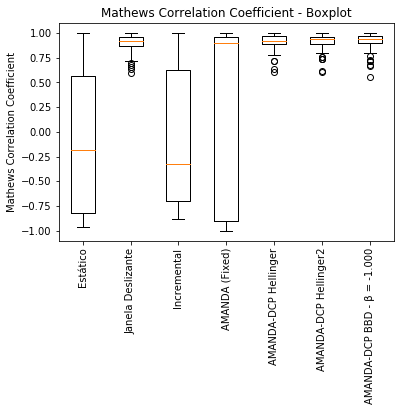

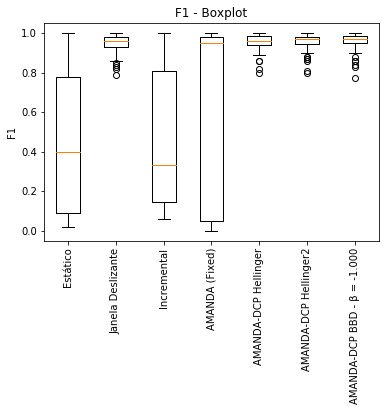

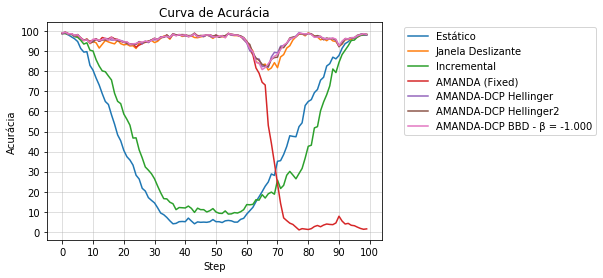

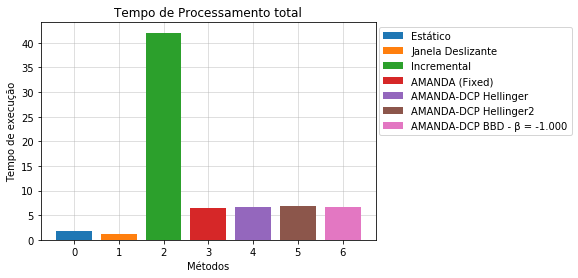

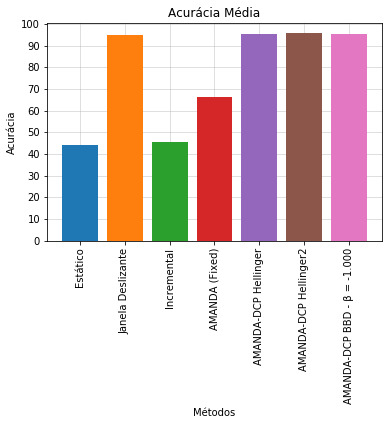

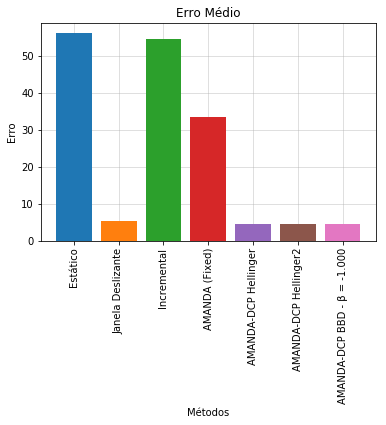

Pos 4 - Redução do Erro (Janela Deslizante):115.63470801475508
Pos 6 - Redução do Erro (Incremental):3.2373315382271297
Pos 5 - Redução do Erro (AMANDA (Fixed)):51.16689484528584
Pos 3 - Redução do Erro (AMANDA-DCP Hellinger):117.2848715301309
Pos 1 - Redução do Erro (AMANDA-DCP Hellinger2):117.52207116443867
Pos 2 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):117.3892575628704


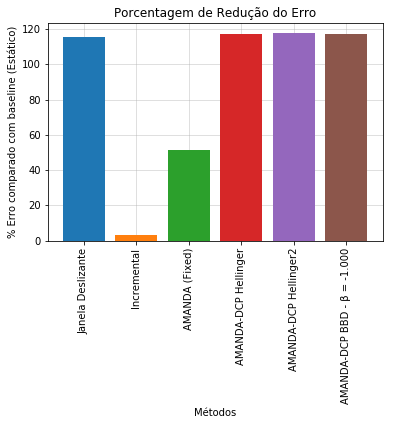

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadUG_2C_2D(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 5, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 5, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 5, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 5, 0.85, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 11, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [9, 9, 10, 12]
    betas = [-1]
    bestK = [9]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])

    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier, 'HDDDM')
    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 11)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'UG_2C_2D', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()